# Import Modules

In [2]:
import os
import pickle
import numpy as np
import random
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model, get_file
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-06-08 17:08:30.554674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 17:08:30.554781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 17:08:30.685606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Extract Image Features


In [4]:
local_weights_path = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
model = VGG16(weights=local_weights_path)

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1717866530.148859  544212 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

# Preprocess Text Data

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
clean(mapping)

In [15]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

8485

In [21]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

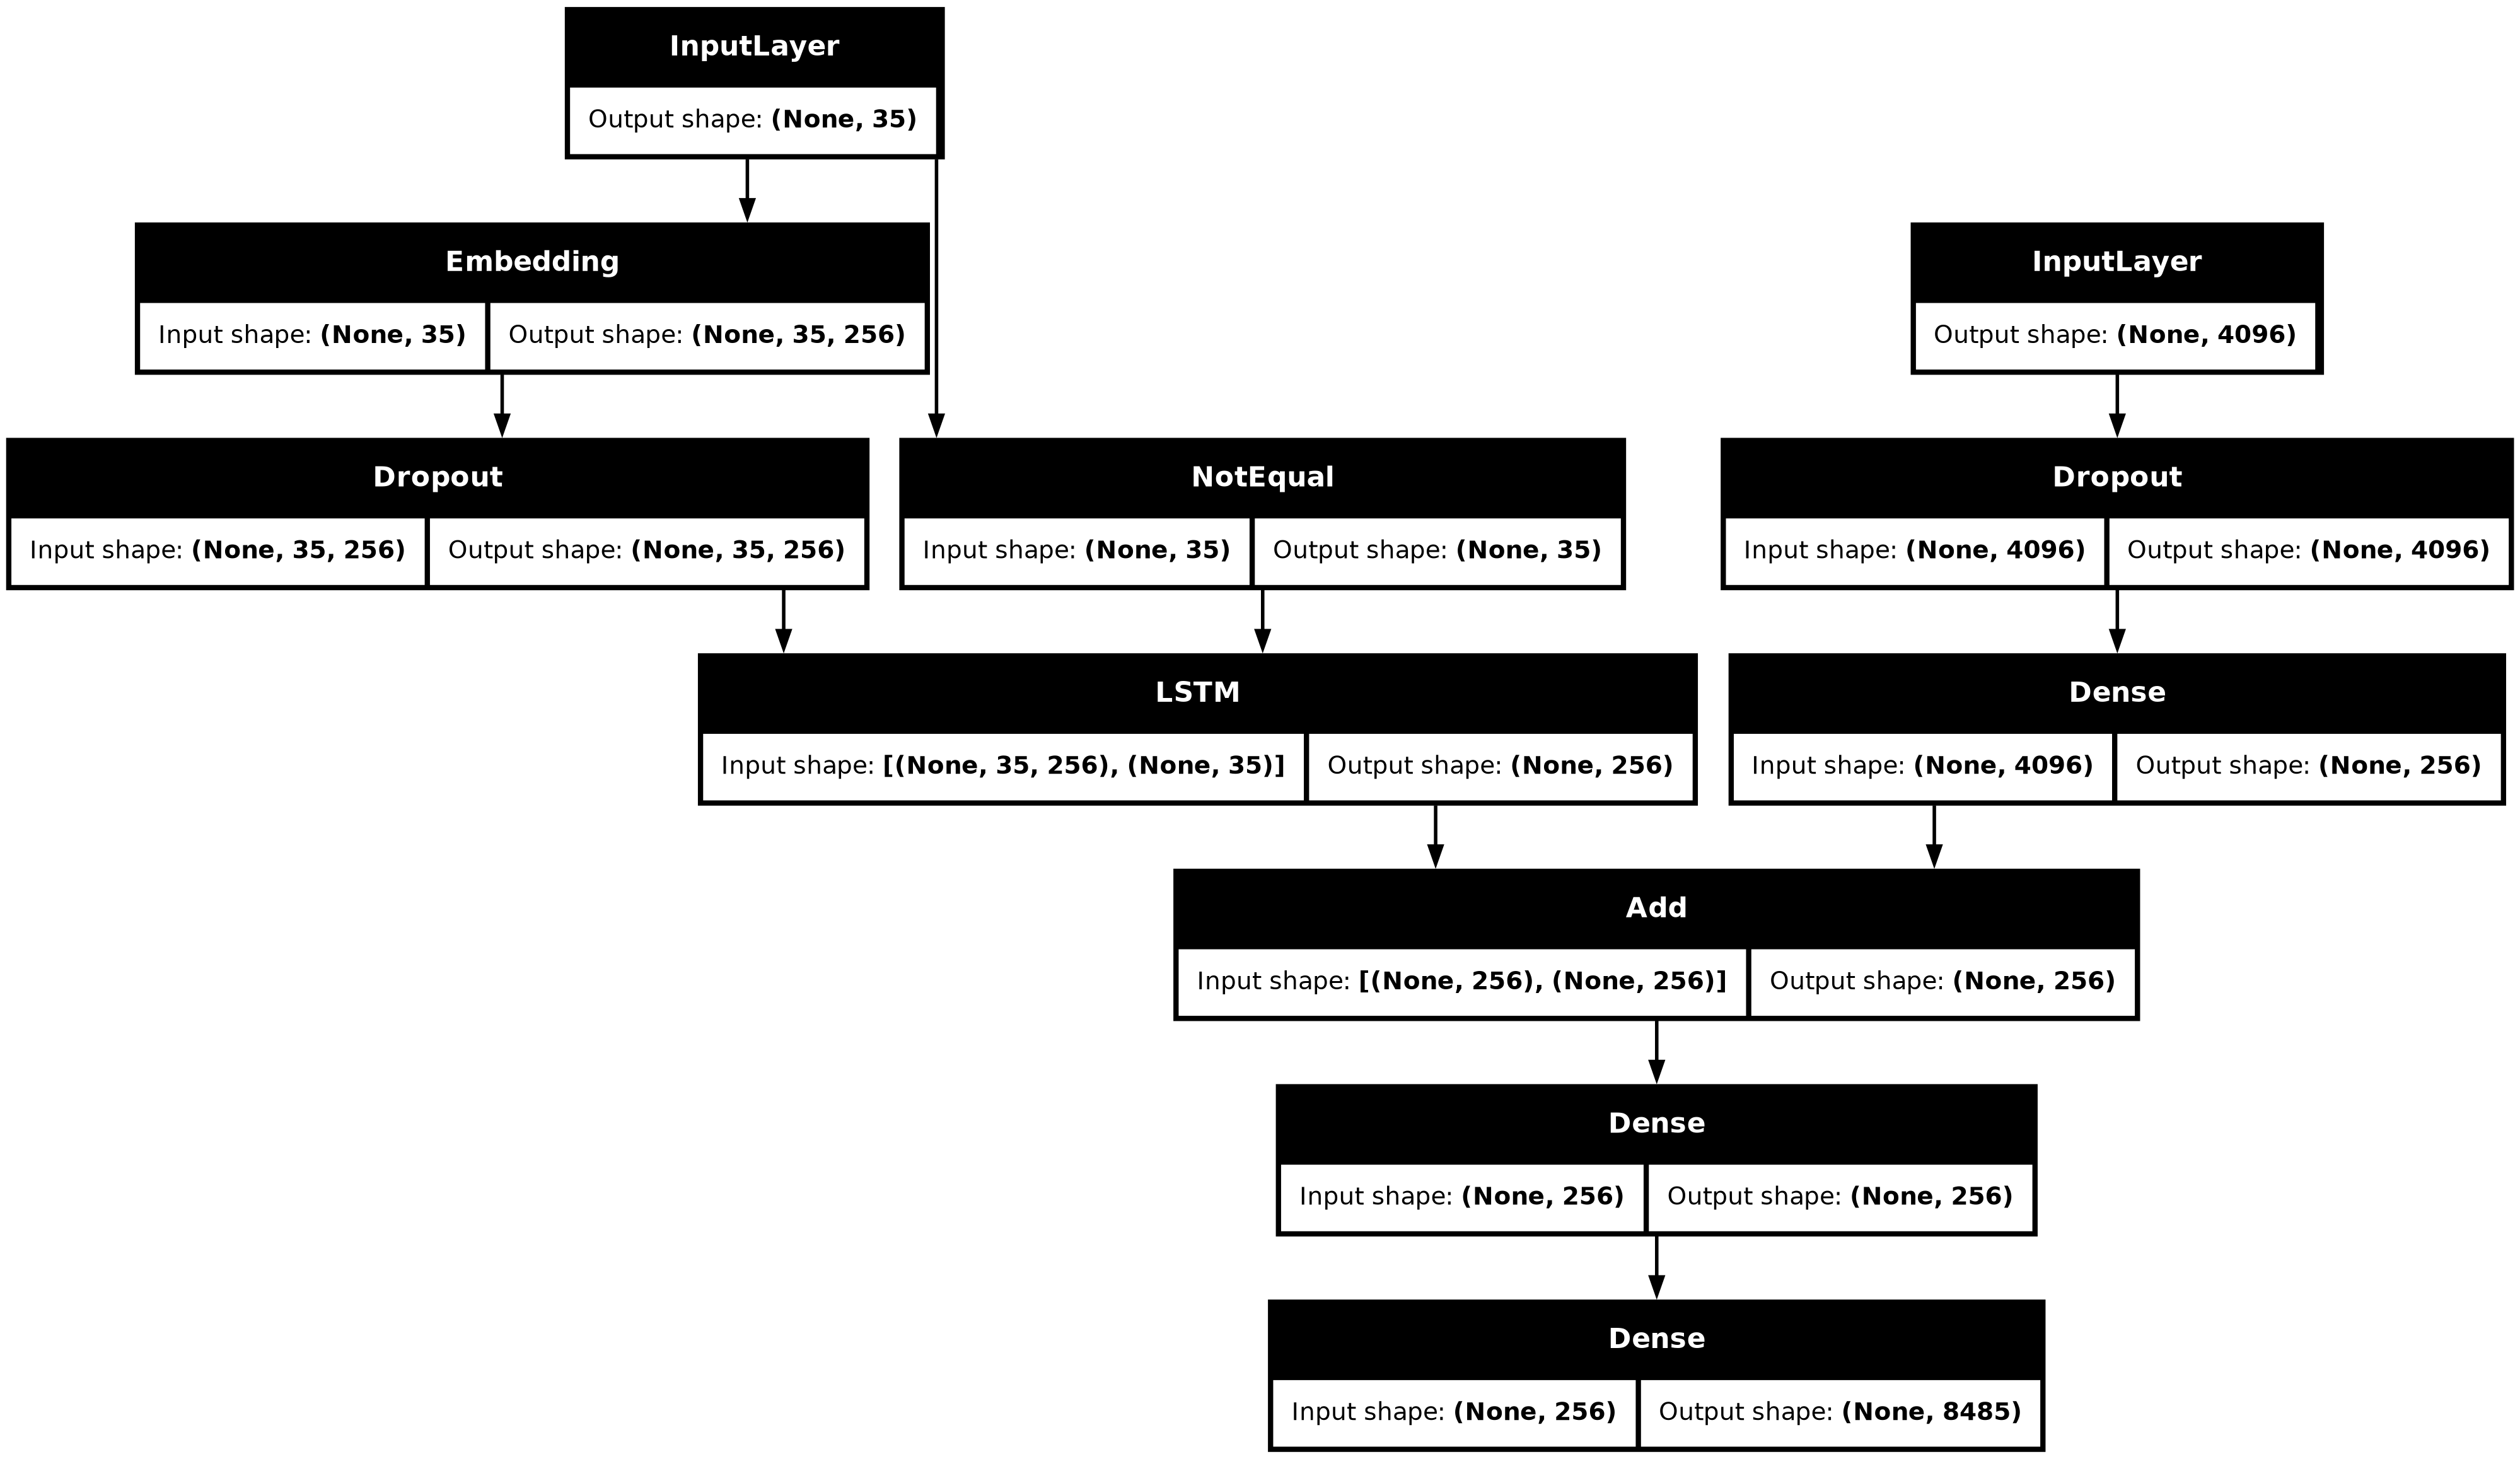

In [25]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)  

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [26]:
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

W0000 00:00:1717867407.729121  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867407.832955  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/113 ━━━━━━━━━━━━━━━━━━━━ 15:44 8s/step - loss: 9.1166

W0000 00:00:1717867407.936930  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867412.990080  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867413.090552  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867413.186137  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/113 ━━━━━━━━━━━━━━━━━━━━ 9:42 5s/step - loss: 9.0075 

W0000 00:00:1717867418.400961  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867418.501464  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867418.596331  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/113 ━━━━━━━━━━━━━━━━━━━━ 9:46 5s/step - loss: 8.8714

W0000 00:00:1717867423.722519  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867423.826566  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/113 ━━━━━━━━━━━━━━━━━━━━ 9:41 5s/step - loss: 8.6977

W0000 00:00:1717867423.952212  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867428.959686  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867429.064200  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/113 ━━━━━━━━━━━━━━━━━━━━ 9:33 5s/step - loss: 8.5351

W0000 00:00:1717867429.187647  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867434.163455  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867434.265415  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  6/113 ━━━━━━━━━━━━━━━━━━━━ 9:26 5s/step - loss: 8.3868

W0000 00:00:1717867434.388329  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/113 ━━━━━━━━━━━━━━━━━━━━ 9:20 5s/step - loss: 8.2566

W0000 00:00:1717867439.527878  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867439.642683  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867444.849417  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867444.949615  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/113 ━━━━━━━━━━━━━━━━━━━━ 9:16 5s/step - loss: 8.1442

W0000 00:00:1717867445.061914  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867450.200243  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867450.300673  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/113 ━━━━━━━━━━━━━━━━━━━━ 9:12 5s/step - loss: 8.0413

W0000 00:00:1717867450.422932  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867455.531402  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867455.632573  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/113 ━━━━━━━━━━━━━━━━━━━━ 9:06 5s/step - loss: 7.9497

W0000 00:00:1717867455.733331  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867460.894528  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867460.998636  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/113 ━━━━━━━━━━━━━━━━━━━━ 9:02 5s/step - loss: 7.8663

W0000 00:00:1717867461.112827  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867466.409383  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867466.523781  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/113 ━━━━━━━━━━━━━━━━━━━━ 8:58 5s/step - loss: 7.7906

W0000 00:00:1717867466.618568  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867471.764146  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867471.865330  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/113 ━━━━━━━━━━━━━━━━━━━━ 8:53 5s/step - loss: 7.7220

W0000 00:00:1717867471.976056  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867477.014202  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867477.116617  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/113 ━━━━━━━━━━━━━━━━━━━━ 8:47 5s/step - loss: 7.6595

W0000 00:00:1717867477.228234  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867482.443061  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867482.546842  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/113 ━━━━━━━━━━━━━━━━━━━━ 8:42 5s/step - loss: 7.6016

W0000 00:00:1717867482.647202  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867487.577715  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867487.680141  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/113 ━━━━━━━━━━━━━━━━━━━━ 8:36 5s/step - loss: 7.5476

W0000 00:00:1717867487.803512  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867493.170112  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867493.173463  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867493.273828  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/113 ━━━━━━━━━━━━━━━━━━━━ 8:32 5s/step - loss: 7.4973

W0000 00:00:1717867493.396337  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867498.701815  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867498.705095  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867498.828326  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/113 ━━━━━━━━━━━━━━━━━━━━ 8:28 5s/step - loss: 7.4498

W0000 00:00:1717867498.926010  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867503.933094  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867504.034125  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/113 ━━━━━━━━━━━━━━━━━━━━ 8:22 5s/step - loss: 7.4053

W0000 00:00:1717867504.134846  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867509.162073  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867509.264732  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/113 ━━━━━━━━━━━━━━━━━━━━ 8:16 5s/step - loss: 7.3633

W0000 00:00:1717867509.364172  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867514.441658  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867514.543457  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/113 ━━━━━━━━━━━━━━━━━━━━ 8:10 5s/step - loss: 7.3237

W0000 00:00:1717867514.650241  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867519.853949  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867519.954139  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867520.054203  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/113 ━━━━━━━━━━━━━━━━━━━━ 8:05 5s/step - loss: 7.2862

W0000 00:00:1717867525.198164  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867525.292990  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867525.396905  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/113 ━━━━━━━━━━━━━━━━━━━━ 8:00 5s/step - loss: 7.2505

W0000 00:00:1717867530.589430  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867530.697943  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/113 ━━━━━━━━━━━━━━━━━━━━ 7:55 5s/step - loss: 7.2162

W0000 00:00:1717867530.813524  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867536.059158  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867536.163626  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/113 ━━━━━━━━━━━━━━━━━━━━ 7:50 5s/step - loss: 7.1835

W0000 00:00:1717867536.261115  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867541.632067  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867541.741807  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/113 ━━━━━━━━━━━━━━━━━━━━ 7:46 5s/step - loss: 7.1522

W0000 00:00:1717867541.860566  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867547.155768  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867547.159207  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867547.261716  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/113 ━━━━━━━━━━━━━━━━━━━━ 7:41 5s/step - loss: 7.1223

W0000 00:00:1717867547.358980  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867552.685964  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867552.789871  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/113 ━━━━━━━━━━━━━━━━━━━━ 7:36 5s/step - loss: 7.0941

W0000 00:00:1717867552.909019  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867558.276330  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867558.279878  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867558.381929  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 29/113 ━━━━━━━━━━━━━━━━━━━━ 7:31 5s/step - loss: 7.0674

W0000 00:00:1717867558.523673  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867563.838180  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867563.841535  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867563.942295  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 30/113 ━━━━━━━━━━━━━━━━━━━━ 7:26 5s/step - loss: 7.0415

W0000 00:00:1717867564.042028  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867569.270117  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867569.373013  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/113 ━━━━━━━━━━━━━━━━━━━━ 7:21 5s/step - loss: 7.0167

W0000 00:00:1717867569.485027  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867574.610142  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867574.705051  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/113 ━━━━━━━━━━━━━━━━━━━━ 7:16 5s/step - loss: 6.9928

W0000 00:00:1717867574.812362  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867580.006019  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867580.115559  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/113 ━━━━━━━━━━━━━━━━━━━━ 7:10 5s/step - loss: 6.9699

W0000 00:00:1717867580.228314  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867585.412665  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867585.522127  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 34/113 ━━━━━━━━━━━━━━━━━━━━ 7:05 5s/step - loss: 6.9477

W0000 00:00:1717867585.642846  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867590.948410  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867590.951709  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867591.051796  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/113 ━━━━━━━━━━━━━━━━━━━━ 7:00 5s/step - loss: 6.9264

W0000 00:00:1717867591.164188  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867596.319025  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867596.414109  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/113 ━━━━━━━━━━━━━━━━━━━━ 6:54 5s/step - loss: 6.9057

W0000 00:00:1717867596.521252  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867601.861001  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867601.962913  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/113 ━━━━━━━━━━━━━━━━━━━━ 6:49 5s/step - loss: 6.8856

W0000 00:00:1717867602.086006  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867607.247915  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867607.348246  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/113 ━━━━━━━━━━━━━━━━━━━━ 6:44 5s/step - loss: 6.8662

W0000 00:00:1717867607.468989  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867612.756700  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867612.850887  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/113 ━━━━━━━━━━━━━━━━━━━━ 6:39 5s/step - loss: 6.8474

W0000 00:00:1717867612.967843  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867618.191373  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867618.300296  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/113 ━━━━━━━━━━━━━━━━━━━━ 6:33 5s/step - loss: 6.8292

W0000 00:00:1717867618.404969  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867623.664564  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867623.775115  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/113 ━━━━━━━━━━━━━━━━━━━━ 6:28 5s/step - loss: 6.8116

W0000 00:00:1717867623.868098  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/113 ━━━━━━━━━━━━━━━━━━━━ 6:14 5s/step - loss: 6.7946

W0000 00:00:1717867629.710038  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867629.816471  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/113 ━━━━━━━━━━━━━━━━━━━━ 6:09 5s/step - loss: 6.7781

W0000 00:00:1717867629.917655  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 44/113 ━━━━━━━━━━━━━━━━━━━━ 5:56 5s/step - loss: 6.7620

W0000 00:00:1717867635.412295  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867635.511816  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/113 ━━━━━━━━━━━━━━━━━━━━ 5:51 5s/step - loss: 6.7464

W0000 00:00:1717867635.631835  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867640.961372  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867641.067579  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867641.160388  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/113 ━━━━━━━━━━━━━━━━━━━━ 5:34 5s/step - loss: 6.7165

W0000 00:00:1717867646.735261  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867646.842978  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/113 ━━━━━━━━━━━━━━━━━━━━ 5:30 5s/step - loss: 6.7021

W0000 00:00:1717867646.950133  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867652.245068  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867652.248163  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867652.348314  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/113 ━━━━━━━━━━━━━━━━━━━━ 5:26 5s/step - loss: 6.6880

W0000 00:00:1717867652.482940  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867657.787462  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867657.894044  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 50/113 ━━━━━━━━━━━━━━━━━━━━ 5:21 5s/step - loss: 6.6742

W0000 00:00:1717867657.992601  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867663.300616  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867663.304163  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867663.402651  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/113 ━━━━━━━━━━━━━━━━━━━━ 5:16 5s/step - loss: 6.6609

W0000 00:00:1717867663.541969  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867668.769674  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867668.772740  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867668.888086  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/113 ━━━━━━━━━━━━━━━━━━━━ 5:12 5s/step - loss: 6.6478

W0000 00:00:1717867669.003675  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867674.364293  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867674.367716  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867674.466237  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/113 ━━━━━━━━━━━━━━━━━━━━ 5:07 5s/step - loss: 6.6351

W0000 00:00:1717867674.605034  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867679.863766  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867679.971488  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/113 ━━━━━━━━━━━━━━━━━━━━ 5:02 5s/step - loss: 6.6227

W0000 00:00:1717867680.082692  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867685.367016  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867685.370316  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867685.469411  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/113 ━━━━━━━━━━━━━━━━━━━━ 4:58 5s/step - loss: 6.6105

W0000 00:00:1717867685.583671  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867690.789063  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867690.882397  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867690.986493  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/113 ━━━━━━━━━━━━━━━━━━━━ 4:53 5s/step - loss: 6.5987

W0000 00:00:1717867696.333111  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867696.336489  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867696.430339  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/113 ━━━━━━━━━━━━━━━━━━━━ 4:48 5s/step - loss: 6.5871

W0000 00:00:1717867696.546296  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867701.873519  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867701.974171  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/113 ━━━━━━━━━━━━━━━━━━━━ 4:43 5s/step - loss: 6.5759

W0000 00:00:1717867702.095309  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867707.335667  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867707.338978  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867707.455694  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 59/113 ━━━━━━━━━━━━━━━━━━━━ 4:38 5s/step - loss: 6.5650

W0000 00:00:1717867707.571748  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/113 ━━━━━━━━━━━━━━━━━━━━ 4:29 5s/step - loss: 6.5542

W0000 00:00:1717867713.079901  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867713.083207  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867713.181178  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/113 ━━━━━━━━━━━━━━━━━━━━ 4:24 5s/step - loss: 6.5437

W0000 00:00:1717867713.290642  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867718.484228  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867718.583518  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 62/113 ━━━━━━━━━━━━━━━━━━━━ 4:19 5s/step - loss: 6.5335

W0000 00:00:1717867718.691005  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867724.230692  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867724.337769  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/113 ━━━━━━━━━━━━━━━━━━━━ 4:15 5s/step - loss: 6.5235

W0000 00:00:1717867724.458067  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867729.720292  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867729.828779  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/113 ━━━━━━━━━━━━━━━━━━━━ 4:10 5s/step - loss: 6.5137

W0000 00:00:1717867729.927749  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867735.117141  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867735.210100  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867735.310240  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/113 ━━━━━━━━━━━━━━━━━━━━ 4:05 5s/step - loss: 6.5040

W0000 00:00:1717867740.632034  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867740.635296  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867740.736814  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/113 ━━━━━━━━━━━━━━━━━━━━ 4:00 5s/step - loss: 6.4946

W0000 00:00:1717867740.878785  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/113 ━━━━━━━━━━━━━━━━━━━━ 3:52 5s/step - loss: 6.4852

W0000 00:00:1717867746.431870  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867746.530239  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867746.630315  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 68/113 ━━━━━━━━━━━━━━━━━━━━ 3:47 5s/step - loss: 6.4761

W0000 00:00:1717867751.845494  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867751.944736  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/113 ━━━━━━━━━━━━━━━━━━━━ 3:42 5s/step - loss: 6.4671

W0000 00:00:1717867752.056005  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867757.458426  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867757.569323  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/113 ━━━━━━━━━━━━━━━━━━━━ 3:37 5s/step - loss: 6.4583

W0000 00:00:1717867757.663364  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867763.015919  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867763.118501  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 71/113 ━━━━━━━━━━━━━━━━━━━━ 3:33 5s/step - loss: 6.4496

W0000 00:00:1717867763.229627  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867768.462678  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867768.569506  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/113 ━━━━━━━━━━━━━━━━━━━━ 3:28 5s/step - loss: 6.4411

W0000 00:00:1717867768.668009  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867774.010480  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867774.104844  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/113 ━━━━━━━━━━━━━━━━━━━━ 3:23 5s/step - loss: 6.4327

W0000 00:00:1717867774.217739  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867779.533397  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867779.536771  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867779.630738  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867779.733337  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/113 ━━━━━━━━━━━━━━━━━━━━ 3:18 5s/step - loss: 6.4244

W0000 00:00:1717867785.077221  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867785.178713  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/113 ━━━━━━━━━━━━━━━━━━━━ 3:13 5s/step - loss: 6.4163

W0000 00:00:1717867785.310803  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867790.673563  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867790.767680  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/113 ━━━━━━━━━━━━━━━━━━━━ 3:08 5s/step - loss: 6.4083

W0000 00:00:1717867790.879536  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867796.269002  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867796.369139  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 77/113 ━━━━━━━━━━━━━━━━━━━━ 3:04 5s/step - loss: 6.4004

W0000 00:00:1717867796.490389  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867801.773880  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867801.881196  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/113 ━━━━━━━━━━━━━━━━━━━━ 2:59 5s/step - loss: 6.3927

W0000 00:00:1717867801.986421  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867807.251511  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867807.349535  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 79/113 ━━━━━━━━━━━━━━━━━━━━ 2:54 5s/step - loss: 6.3850

W0000 00:00:1717867807.455235  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 80/113 ━━━━━━━━━━━━━━━━━━━━ 2:46 5s/step - loss: 6.3774

W0000 00:00:1717867812.882899  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867812.981409  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867813.076255  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/113 ━━━━━━━━━━━━━━━━━━━━ 2:42 5s/step - loss: 6.3700

W0000 00:00:1717867818.444325  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867818.543952  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/113 ━━━━━━━━━━━━━━━━━━━━ 2:37 5s/step - loss: 6.3626

W0000 00:00:1717867818.653952  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867823.776401  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867823.874772  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/113 ━━━━━━━━━━━━━━━━━━━━ 2:32 5s/step - loss: 6.3553

W0000 00:00:1717867823.999034  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/113 ━━━━━━━━━━━━━━━━━━━━ 2:25 5s/step - loss: 6.3481

W0000 00:00:1717867829.566641  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867829.569906  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867829.669043  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 85/113 ━━━━━━━━━━━━━━━━━━━━ 2:20 5s/step - loss: 6.3409

W0000 00:00:1717867829.778570  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867834.829347  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867834.922931  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/113 ━━━━━━━━━━━━━━━━━━━━ 2:15 5s/step - loss: 6.3338

W0000 00:00:1717867835.034884  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867840.308591  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867840.414974  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/113 ━━━━━━━━━━━━━━━━━━━━ 2:10 5s/step - loss: 6.3269

W0000 00:00:1717867840.532507  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867845.839523  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867845.842696  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867845.941900  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/113 ━━━━━━━━━━━━━━━━━━━━ 2:05 5s/step - loss: 6.3200

W0000 00:00:1717867846.051035  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867851.215263  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867851.314755  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/113 ━━━━━━━━━━━━━━━━━━━━ 2:00 5s/step - loss: 6.3132

W0000 00:00:1717867851.417041  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867856.594728  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867856.702101  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/113 ━━━━━━━━━━━━━━━━━━━━ 1:56 5s/step - loss: 6.3064

W0000 00:00:1717867856.815367  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/113 ━━━━━━━━━━━━━━━━━━━━ 1:49 5s/step - loss: 6.2998

W0000 00:00:1717867862.521167  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867862.629320  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/113 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - loss: 6.2932

W0000 00:00:1717867862.726949  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867868.076996  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867868.184822  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/113 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - loss: 6.2867

W0000 00:00:1717867868.287470  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867873.581173  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867873.679126  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/113 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 6.2803

W0000 00:00:1717867873.785494  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867879.063608  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867879.157880  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 95/113 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - loss: 6.2739

W0000 00:00:1717867879.270639  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867884.638815  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867884.642057  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867884.747320  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 96/113 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 6.2677

W0000 00:00:1717867884.870971  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867890.025283  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867890.124562  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867890.220052  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 99/113 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - loss: 6.2492

W0000 00:00:1717867896.033372  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867896.037032  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867896.137603  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/113 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - loss: 6.2431

W0000 00:00:1717867896.245683  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/113 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 6.2372 

W0000 00:00:1717867901.941832  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867902.042896  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/113 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 6.2312

W0000 00:00:1717867902.164293  544214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867907.456914  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867907.564059  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/113 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 6.2254

W0000 00:00:1717867907.668148  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867913.059089  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867913.062481  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867913.173446  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/113 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 6.2196

W0000 00:00:1717867913.272575  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867918.604944  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867918.704736  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/113 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 6.2138

W0000 00:00:1717867918.825832  544212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867924.156811  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867924.264132  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867924.356891  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/113 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 6.2024

W0000 00:00:1717867929.945034  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867930.053598  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/113 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 6.1969

W0000 00:00:1717867930.154238  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867935.464324  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867935.562633  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/113 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 6.1913

W0000 00:00:1717867935.681335  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/113 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 6.1804 

W0000 00:00:1717867941.563279  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867941.662066  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/113 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 6.1749

W0000 00:00:1717867941.777296  544211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867947.069615  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867947.072830  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867947.172493  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717867947.266792  544213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 548s 5s/step - loss: 6.1643
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - loss: 4.4958
113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 531ms/step - loss: 3.7976
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - loss: 3.4843
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 518ms/step - loss: 3.2663
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 514ms/step - loss: 3.1005
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 507ms/step - loss: 2.9726
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 521ms/step - loss: 2.8738
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 518ms/step - loss: 2.7918
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - loss: 2.7236
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 523ms/step - loss: 2.6593
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 517ms/step - loss: 2.5936
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 523ms/step - loss: 2.5382
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 518ms/step - loss: 2.4857
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - loss: 2.4395
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 519ms/step - loss: 2.3936
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 516ms/step - loss: 2.3504

In [27]:
model.save(WORKING_DIR+'/best_model.h5')

# Generate Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.552357
BLEU-2: 0.318630


# Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the sidewalk endseq


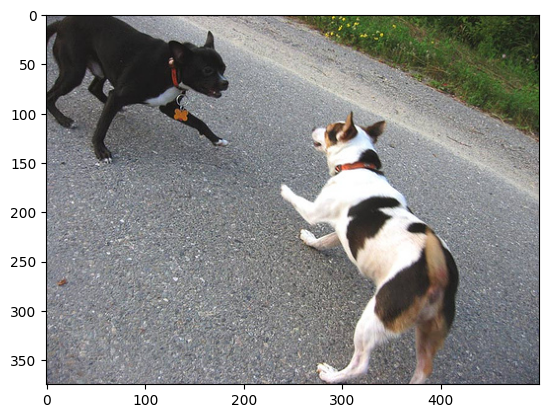

In [37]:
generate_caption("1001773457_577c3a7d70.jpg")

# Test with Real Images

In [33]:
vgg_model = VGG16(weights=local_weights_path)
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [35]:
image_path = '/kaggle/input/flickr8k/Images/1009434119_febe49276a.jpg'
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)
predict_caption(model, feature, tokenizer, max_length)

'startseq boston terrier is running on the grass endseq'